# Stabilizing the Cart-Pole system

In this exercise, we will use LQR to stabilize a cart-pole system and then adapt the LQR controller to get the robot to move along a specified path.

<img src="cart_pole.png" alt="drawing" width="400"/>

The difficulty of the cart-pole system is that we can only move the cart back and forth (using $u$) to move both the cart and the pendulum. Therefore, it is not trivial to find a good controller to get the pendulum to stay balanced on top of the cart while moving the cart around. We will see how we can use our optimal control approach to do such things.

In [1]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

## The cart-pole model

The dynamics of the cart-pole can be written as
\begin{align} 
\dot{x} &= v\\
\dot{\theta} &= \omega\\
\dot{v} &= \frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \\
 \dot{\omega} &= \frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\end{align}
 
There are four states: the position $x$ and linear velocity $v$ of the cart, the angle of the pendulum $\theta$ and its angular velocity $\omega$. There is one control input $u$ which is the force applied on the cart. We will write $z = \begin{bmatrix} x & \theta & v & \omega \end{bmatrix}^T$ the state vector.

We know that the point where the pendulum is vertical is an unstable fixed point of the system. We would like to stabilize the fixed point $\bar{z} = \begin{bmatrix} \bar{x} & \bar{\theta} & \bar{v} & \bar{\omega} \end{bmatrix}^T = \begin{bmatrix} 0 & \pi & 0 & 0 \end{bmatrix}^T$.

Like most robotic systems, it is not linear. It is also underactuated, i.e. we have only one control input to control two degrees of freedom.

We will first linearize the system around $\bar{z}$ (with $\bar{u}=0$) and then compute a LQR control law to stabilize it. The control law will be approximately optimal for the nonlinear system but should be a good enough approximation when sufficiently close to the fixed point.

## Linearizing the dynamics
We linearize $\dot{z} = f(z,u) \simeq f(\bar{z},\bar{u}) + \frac{\partial f}{\partial z}_{|z=\bar{z}, u=\bar{u}} (z - \bar{z}) + \frac{\partial f}{\partial u}_{|z=\bar{z}, u=\bar{u}}(u - \bar{u})$.

We have $f(\bar{z},\bar{u}) = 0$. 

Next, we compute the partial derivatives of the dynamics with respect to all state and control variables.

For the first two equations, this is straightforward:
\begin{equation}\frac{\partial}{\partial x} v = 0,\ \frac{\partial}{\partial \theta} v = 0, \ \frac{\partial}{\partial v} v = 1,\ \frac{\partial}{\partial \omega} v = 0\end{equation}
\begin{equation}\frac{\partial}{\partial x} \omega = 0,\ \frac{\partial}{\partial \theta} \omega = 0, \ \frac{\partial}{\partial v} \omega = 0,\ \frac{\partial}{\partial \omega} \omega = 1\end{equation}

For the third equation:
$$\frac{\partial}{\partial x} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{(m_p\cos\theta(l \omega^2 + g \cos\theta) - m_pg\sin^2\theta)(m_c  + m_p \sin^2 \theta) - (u + m_p \sin\theta (l \omega^2 + g \cos\theta)) (2m_p \sin\theta\cos\theta) }{(m_c  + m_p \sin^2 \theta)^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{m_p g}{m_c}$$
Now for the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = 0$$
and for the angular velocity
$$\frac{\partial}{\partial \omega} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{2m_p \sin\theta l \omega}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0

Finally we have
$$\frac{\partial}{\partial x} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{(u\sin\theta - m_p l \omega^2 (\cos^2\theta - \sin^2 \theta) - (m_c + m_p)g\cos\theta) (l(m_c  + m_p \sin^2 \theta)) - (-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta)(2l m_p \sin\theta\cos\theta)}{(l(m_c  + m_p \sin^2 \theta))^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{(m_p + m_c) g}{lm_c}$$
For the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
and finally
$$\frac{\partial}{\partial \omega} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{- 2m_p l \omega\cos\theta \sin\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0.

We now compute the partial derivatives with respect to the control command. We have
$$\frac{\partial}{\partial u} v = 0$$
$$\frac{\partial}{\partial u} \omega = 0$$
$$\frac{\partial}{\partial u} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{1}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{m_c}$$
and the last one
$$\frac{\partial}{\partial u} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{-\cos\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{lm_c}$$

We can gather all these terms and get the linearized dynamics
$$\dot{z} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} (z - \bar{z}) + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} (u-\bar{u})$$

Finally, we change coordinates to center around the linearized point, we set $\tilde{z} = z - \bar{z}$ and $\tilde{u} = u-\bar{u}$ and get the following dynamics
$$\dot{\tilde{z}} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} \tilde{z} + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} \tilde{u}$$


## Discretizing the dynamics
We now discretize the dynamics, using $\Delta t$ for the integration step. We have 
$$\tilde{z}_{n+1} = \tilde{z}_n + \Delta t \left( \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} \tilde{z}_n + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} \tilde{u}_n \right)$$
or equivalently
$$\tilde{z}_{n+1} =  \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & \Delta t\frac{m_p g}{m_c} & 1 & 0 \\ 0 & \Delta t\frac{(m_p + m_c) g}{lm_c} & 0 & 1 \end{bmatrix} \tilde{z}_n + \begin{bmatrix} 0 \\ 0 \\ \frac{\Delta t}{m_c} \\ \frac{\Delta t}{lm_c} \end{bmatrix} \tilde{u}_n $$

We now have an approximation of the dynamics in a form that can be used to compute linear optimal controllers (i.e. LQR). The controllers we will compute will be of the form $$ \tilde{u}_n = K_n \tilde{z}_n + k_n$$
and they will need to be transformed into
$$ u_n = K_n (z_n - \bar{z}) + k_n$$
to be used on the original system.

## Simulating the cart pole system with arbitrary controllers

Below are a few helper functions to simulate the cart-pole system and display its behavior

In [2]:
class CartPole:
    """
    This class describes a cart pole model and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class, takes as input desired discretization number
        for x (angle), v (angular velocity) and u (control) and the maximum control
        """
        #store discretization information
        self.road_length = 3.
        
        #gravity constant
        self.g=9.81

        #integration step
        self.dt = 0.01
        
        #we define lengths and masses
        self.l = 1.0
        self.mc = 5.0
        self.mp = 1.0
            
    def next_state(self,z,u):
        """
        Inputs:
        z: state of the cart pole syste as a numpy array (x,theta,v,omega)
        u: control as a scalar number
        
        Output:
        the new state of the pendulum as a numpy array
        """
        x = z[0]
        th = z[1]
        v = z[2]
        om = z[3]
        x_next = (x + self.dt * v)
        th_next = (th + self.dt * om)
        v_next = v + self.dt*((u + self.mp*np.sin(th)*(self.l*om**2 + self.g * np.cos(th)))/(self.mc+self.mp*np.sin(th)**2))
        w_next = om + self.dt*((-u*np.cos(th)-self.mp*self.l*(om**2)*np.cos(th)*np.sin(th)-(self.mc+self.mp)*self.g*np.sin(th))/(self.mc+self.mp*np.sin(th)**2))
        z = np.array([x_next,th_next,v_next,w_next])
        return z
    
    def simulate(self, z0, controller, horizon_length):
        """
        This function simulates the pendulum of horizon_length steps from initial state x0
        
        Inputs:
        z0: the initial conditions of the pendulum as a numpy array (x,theta,v,omega)
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[4xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        z=np.empty([4, horizon_length+1])
        z[:,0] = z0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = controller(z[:,i],i)
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        #print(z)
        
        return z, u        

In [3]:
def animate_cart_pole(x, dt):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    plotx = x[:,::steps]
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4.25,4.25], ylim=[-1.,1.4])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[1,i])
        y_pend = cart_height - np.cos(plotx[1,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

<IPython.core.display.Javascript object>


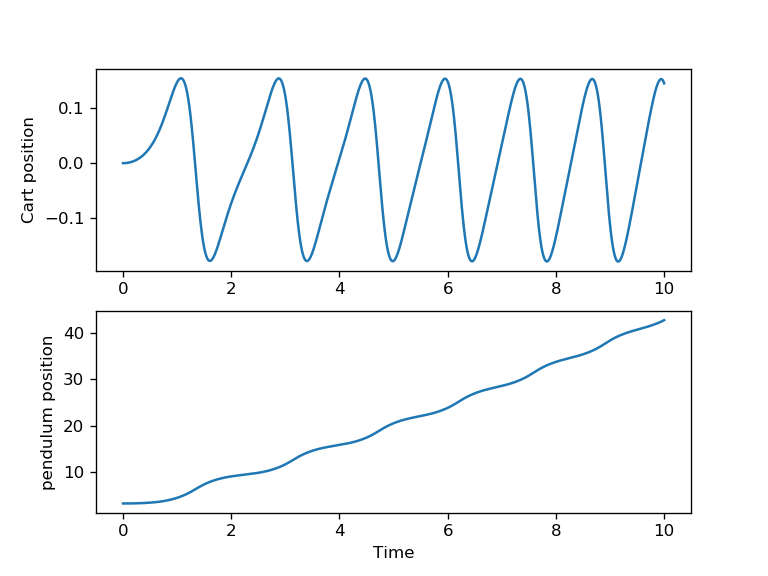

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACAF21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA+AZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAAwAAdaFhgCmhz+EeJXEB8N6fIJ7J
rhIV+NN9XHf+yK6HeTLxVohwsVcDo5RFQnt96ggNjzTuW/beQ9Ceg3f9LFZ5ZPoaVjdmAKgN7/Gc
Kr0gtL00uCkVv1C53J99XsNJS/gMh9fGR78jKGqiLQYpnc7fg6Gpmja2JwPurpkXHfl1gpDCA/ni
GRiQrPLlt2OPB05Qm73KqD/tHmPdnwiciUPTyOfO6Zk07JaciEI6Yzb1U3ur4ZDCUntx2SEy8nWx
NJ2p4hAZhmqmaecLjIeScUwnm9E0sSwKPUt1k7A4B5UEP2CBebM5BrR5tzxy8gmROwXuQAIz+7KF
CZMhHJyr7MX0bYv6IL2gPlMmVpE2fPJPvcQdFvc4e1VYi8npFJIgHJFoOdXwSbcwhGs2NCBHE0ps
lk38ndaNzOFTeIKdkGveGqwyaPXaD2lorbo6wo8rTrcp1pUBbE3CDgfvEsITbxzm9cEDuFBQd/DN
dYwVbR51t0KCYkG5stkZTvojtlttshvvLNzkKWdY3mKvY4giSzoDg8ZseSA6lTgCkK9DjTOi108L
CL9gpV1LMXnKL2qq5g/yLv4UOe4p3IIibVJoDBzwhAuSMAl0rRao9tupJfSloHkS1TNfs9NLEgyG
U+k2QEaViM5Dk2Bww1i+sJIs0Pbfi+8k7nem7ws1x2U38EWkqZKYSk3S9QsQyBg0faMFZJqNwaLF
vtAb7oC/MIiMX8w7PlsoP+aekYXUj9ngvyxHfwuB/TsopfbNHePybBhan0FGu+KnM47NWmYA7ptT
GRzswyKLXzzTwdIoQ8dX7glilj0mhzx35Gag3MKH6UqY9IJWDsmypq96UwICSu2BbJrNRciLWqli
eZ3ga9p45iXnU0en+5y0GY+sPE7eRdLxdQgD+dShn00R+oyfj+pHLYV3lxHf2dSJsVlX76DCKyfH
6W5cMC+RbTEe1i4WzlFMmhtYiEHFBGG9ptibPAAAEmLK2rGvzzzuQDnTsfWibS6O//ow6jgmgRYl
SI6k+02tLrnAtN4XKpmexVLUFne86BfEWdNsvQQFKbzo6hiCRv1G3YJyGrO6FXGzquAeYb6SsFrq
MdWUCOltHWgMjMfl6+9hTvCjp/STv/Yqh+J8y9vPw01kzQBYN5l/pI/mYrFivpoO4TS76SGvl9I9
4j+uRXBaZO28hASAF4nrpVlSlxfFY3/AipOgqOE40+fa+bFe/jARKwXDuzqc5K1Mq7b8l9oWC4XR
YD5ItIpQlOiJyZSGVHdsfsC4igB5TAARZ3cNR0GSRG9eLNdxSVy4GS38fN1FYcM5zyFiQo7prMaY
DvL15ooBibHdrS92QWmAAEQ6ccLD7QReELOBt0dSpvAw0HNY39jqs4PvADQY+xtE55QBAZI0Umyg
ieyB8drqB2k8E87JTHXPGFmAdVtACjMpWqNKw/6Bj6nAJNM3ZFZwcLNAIcbBom9GzdagMwSGHTbm
HPIaZhdbxLVh+PeeOq0+mzLO+XFHaBgDDpci4/MnsocjKxNdtNYvGRen21kjJQj4KQ7Ir+zRMZxT
8xTlx/9B7ybvUWhyTSPAfRY0mjKj0UudJ9J2YJlW/8Z70zi45ez8YFt/eYIPK/kAW2ZVtX/O4xEE
gOdEBY4BDMuYTaVb4q4jf1XUrphCtStLV3L5no6REFxZMYjOoDEO2/DMLSK1/DFfQNGepAu+15GW
I7VClwyRUaZ48xLZ2RD8yN6t3QXKs9onbFDiBYRWcZIi5Kh6NrICA2PHQiCjlEDBFUeOSiyIvYvN
fNrbqf5JJMy6hkVlr6LHKeFPGANlxuGhbqsYfnAAxuSXDEv6wSe7KJnV8bEY6BkplvwQZnq3dw98
at9JS4SElYFy1uB5N3w4PShUs6sM51n+jUpLaRtiiil+unUprJp9P2mNeA88I+mK9BpIjt2Pclju
R7EA0vgVaiGN7BMHexGoOJLvxlXvjlcfCbfuSO6DxW9JwX0KE3Fznmx/v+n4e9N3+9gPqnGwYjd3
oAAADvZdGYoKczM2DBw0xBTOMFADz1I5pSiI3vYSxumiWSYaCaLQzojK+xShu+QhjRAsjRKjf98U
rZs+4J/BLfUqGQIhZRcyTUdc861HUSExNnB118nBbOqiV8WFND5zwRgNdHH+ZkpP2U+n+veI3LBN
atKrjkcEVLsGGIqHailHuBYLqdVU5em+AlmUYxVF+JZ1pwM5oDdDhfC8CkkzoMICLodM5sOR4wAc
rKQu3i1UQ3d/x1cR/5Xday5Ln/imR7ePkd27/21oxq13bWijIuw1r8H7LEC1KuXaO8dDjDlsf4+a
xHxk1bmHloBbCttwysdAm6ZOiSHyrLFzw8KZjinWMHXLDP+fLxcACjHkRc6HIu2r7++5B3UMF1GW
ng3OH46zLlnU+ek6usbCt7BEYM6YMEwX0hTw+HN/j48OiVc637iPdhiaKgLK/aQugXEY2MttOnRj
obBUdMpZBiUISitjucbz2+UE3byW9swASxiwsqoqqkm4lf4FmHNZd4KXWl2FGSo5Q92jvPDWONtZ
+Vh0F5kT9ZlS6PjhNOTrBcy/4nzPKMEI3W+/fU52+ADIGCN96gq2Svzi/4CAm/7Hf3VEbtx+rtz9
LiYABiC6pthToLrWZimHXt/ba5UrGhD6XLhEWsc7HvnoYsDXUs84ssVY6vidKdnk3DU5bmjNjzKC
pbaLSamJWiQbUBGp3hUQK0Z6prByI52PphaYSsl/iKOLulDSxEWb+anCkEXqvaLVXUF928oX+Dne
nbMO49MJBjJax+3AyMvt7Besv5f1xV9idrqECcb0MjNIaJTHvyclx76GwOOGybvjW6cXGWdDVd6s
PVZR7MYYaQSvGI1+XmU86

In [4]:
# we show an example on how to simulate the cartpole and display its behavior

# we create a cart pole
cart = CartPole()

# we create a controller that does nothing u(z) = 0
def useless_controller(z,i):
    return 0    

# we simulate the cart pole and display its behavior
z0 = np.array([0,np.pi+0.1,0.,0])
horizon_length = 1000

z,u = cart.simulate(z0, useless_controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')


animate_cart_pole(z, cart.dt)

# Question 1:
We would like to use the linearized equation to compute an optimal controller that stabilizes the system around the resting position.

1. Write a cost function that will help stabilize the resting position $\bar{z}$ (be precise with the variables you use).
2. Compute the infinite horizon gains to stabilize the cart pole system
3. Write a function that can stabilize the system and test the behavior of the robot using $z_0 = [0.5, \pi + 0.3, 0., 0.]^T$. Plot the time evolution of the control input and the states of the system.
4. What is the behavior of the system when starting with $z_0 = [0.5, 0.3, 0., 0.]^T$? Explain the behavior.

### Answers

1. The cost function to stablize the cart model can be computed by solving Ricatti equations. The of form:
$$ min  \sum^{\infty}_{n=0} \frac{1}{2}x^T_n Q_n x_n + \frac{1}{2}u_n R_n u_n $$ 
Here $Q_N$ is the terminal quadratic cost matrix for the system is not requires as it is infinite horizon case. $Q_n$ is quadratic cost matrix computed at each time stamp.$R_n$ is the cost on control inputs.

Using these matrices and solving Ricatti equations for each stage as follows:

$$K_n = -(R_n + B^T_n P_{n+1}B_n)^{-1}B^T_n P_{n+1}A_n$$
$$P_n = Q_n + A^T_n P_{n+1}A_n + A^T_n P_{n+1}B_n K_n$$

Moreover, here the control cost, $R$ (smaller for quick response) and state cost $Q$ matrix were taken as follows:
$$ Q = \begin{bmatrix} 1000 & 0 & 0 & 0 \\ 0 & 10000 & 0 & 0 \\ 0 & 0 & 0.1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}  \text{ and } R = 0.001 $$

2. Infinite horizon gains can be compute by computing the gains iterative till it becomes nearly constant. Taking advantage of this property we performed the iteration to compute gains 100 times. Onchecking the gains were fairly constant, hecne were chosen for further computation. Code implementation for the same is done below.

3. Function for Stablizing the system is given in the following code block:

Final gain, K : [[  435.45242 -3212.83213   400.53969  -693.96767]]


<IPython.core.display.Javascript object>


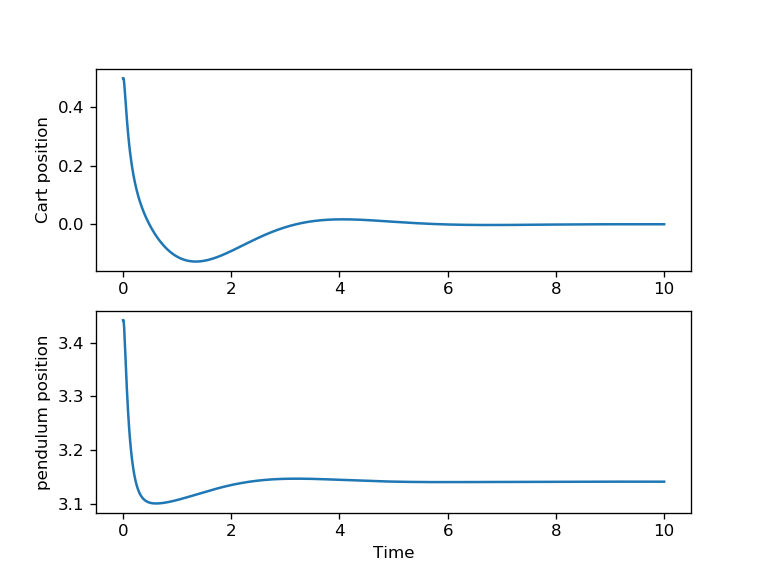

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAu/m1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA/OZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S0FxzClEFKxd1+TNS++zCta62/NP06dt9j0J6Dkf2rHaFv+dr20t1Bp3zX58
DBmkFpamrwUtoW26plf3qfo7kHaQyI08hEByMoaqItBilNRZ9xftAaNrfFzgbRx0zytlSZ7wyT/A
hWDCoOtQa0dEz95yhN3uVkH/sJoWqLvH6jo9pLsuTBPgi8kL8+yRBKPqVQ/YUDgwspb8Gnl6iUwZ
SurlWB0QXIgiBsb9xLD0CubzvixG8obluC6puxpOWyCYkAba0V3dP1mvFov9YwTz1vV8L3LMrXut
l5SYtgJHbmzNn4zNGajSl2IlYeoDBwWABZclutT7XvUlrdXudclCNeGiIx+LfPNRXDTYHhW9yrLJ
OZO9Sz1Ax60e/67dH7A8V12B2UCVHL2ub4PUid9n+nrYiGrtF6+OkrukkNEOOe9jDJlT+qgEPEh+
9OzK34qeaWvdMaE+2nPnqoMOvv9J5m6A4PYZZl8qenYzlZypk7O9wY+xgzX2hMKGqGvtOfd+hEcm
s2dMAGMDIypYR2h1sJXM6ZLOoZX5xDMMdBCkPTXlb8WOrawX8JU/IclyK7tOR9OQKupUWfL6fZ4N
irJ4Q7leG0q/zZ4zaXldjFr9aBA9fRMJR6LY3SjZAH7dJI8dkhZTBosW+0BvuhD8HJqMIl6LtkCD
1nmWBkMNHjSFE7xoimr3s1KgVExXbNbO40/W2PPcW4aEN7m1HHfGXRSzzdWKwo2dULbrGvmPBZZL
TvjmO/L9CQOIHBFtafBhWEuvwQlUnsVzwSfvdRGh+l2ihH9WIHBlMy+wKi/KHzc324fsOASsBwmN
GXAjJPrekOpXhTv3b6Zsk0KCfVgb91v7bcLOCqu2hjztDCnbIjFsXT9oxy6vIHF9Xl56bg0iS8+s
PJ/aYzsqGto0iGynHIspOnAAAAkRZXDPNToMfVgNAIgJ1HijY//9GHc3QHEjk5MSOZPtNrS65wdD
hGbADWA71MbTUSOn3DFqv8ZCn/kKvVVH/domk7J4/ooCEgTP6rGA1EovumhGT+QWgQ+u9ERTe3qO
naz9u50FRLY24tfAqR4RunzLBqd5dW2Ovlo9RpqXzeIE8WrvDhd09BW6eVgEr2Z44SKHhSX0HMpr
jcmW5vNm878XmWS39CO2Kr/AJpkhiaF+hHevmUp3+j7oF9okPZUfv0KPWxNBvW6FUZ2W1bM73+b/
COj2rLH91DL1pCaJ+EdENYaoOkQiTk1CGWAAANKat5yLaoSGp05cAqLH+JL63i75MkNvc2xcd+DP
W6DS+JkZbhHzcpq/ldUO4HRQHps85PzCwRA0BLM3N6FqJfSO8+jdBNAA1+4O44RLcB5uB006RubV
E+mfcodF7xIn/F3WzA4Dz8j97ys+j8vkrAZR8pmC6Xh8wTW/XtdX15Jrd1T2Tfn/9vndQt1Ai1e9
xv/9TtIdppSNTILh7954VySUofojoZ3YmrfC5OPH+Z/hzGZ3DLLhxgMB/I61mLtAwBh0uRcfmVTK
9wBWZ4Wt6wAIFdEbta8dWzoGd6aK191PCweNHbn7e5Zu06urOoq/qBGYbwCy6Z8htfr3ttBUb/g9
++P5samB+xm394ZqNboKre02ihKoRQX2IHUh1/U4iRIis2lUNp90MgXUrphCtStLPXSlvXyYHh1C
kiBy4m5viQTSW2urN9X+BsawWO0Z6zBRM1n6o/4yncW2fil++NqZg2TrMLkSbZ1DsGQ2tgF/fc0x
4oF7PnD7dD3QOvfLjL/QQq9P21+HKbzefkOi0grPX3jCWA6DNAa34CGT/Kso/Bxi9Z2DOLoqQ07E
9Zs6A1SzKBlc6+zZ2+K8iRbVOqNbUfNEJN3B6x50is0BqgABGAiKqrDY56M6ymYxTZ/GdRqadeK0
BOQ6TdVcW/zTFImKfp8CanDQSvK9etauqpt4wO/HGiNjaaJywZLYfElFtsXRXK0KBgR4JkCmtu8G
qNQjbQWzSSxafaWEPH53jEBGwxHZ4+xb+TYQe0FQ6r8Eqn4m8DJJhTYGRBfXiAQjQu4MXxle1rRR
Fv0eN1cAHRDZP/79N+TJif8cvjvEczMo+cuSg+k9BKKOj3a7e/VqK6sw3ildo6grJ82QcKdlj1Yv
lgFzoY7h6HwgYAHfzlDunp+DJqJX9OhUAtFN/XQW7xz6jADPJd2k0A0N9M8BarfsLJdI76myo9tv
xmVc+/IZK7BnPWCuMGM41hZAMR7gtP0g9avp1HdGDUaMFbSZ4pw+TiH6/1vqyHDsq7McNYEVb4aD
NKYrfw+Rjdd2Dokbe9jjqBDvp+FLIwgD4pkmBpoJAfH0w39dT+HmrgEXEbb79AiJP7+ewaPGSeeR
y2P8fNYj4yRH5Dy0AthWjvI4XPtlMnommhVx+tlWlMxxTrGBid5n/XminAAox5EXOhyL7T8ePAZa
yW0GwKgGv0QH51igvKj8/30kFns/UWj5YzXSE7O/hPV9wvuKuyM+QJaWkGRCb8eda7UFtnEDJEUs
0QQ53o6dtfZ3hMKnL3nEblSfJIw/HLTqCGD0xdiM/Fdnm0BcdfWUW+oHhZ8MmJHImNAcPV9jm6T+
NxJGAbrLNP25pbXH7JBR+lx3jUBwFpw93IvvC+fre7wwyiB5JLPmENXyqDxofhRAb3skCltAJzwh
r1s8SGxbUAAoW+u7vFBTO6ikP598HipS10XgE6XK2NFKZjfEo9DFga54BPd/ZjEQPxLHa0zbST4e
dJuTmQXWIn0kZEtRobiXwwPyvLDZ7PxJxEK8dCcC+/zzAgXbAH3Reqx+MUq9V1lkHZpZrgh40F92
8oX+DnenbWDjK9/tywqfp

In [5]:
#Q3 Write a function that can stabilize the system 

# we create a cart pole
testCart = CartPole()

# Create a useful controller
# first computing gains for enough number of iterations such that gains are constant at the end
def Gains():
    # required variables
    g  = testCart.g
    T  = testCart.dt
    L  = testCart.l 
    Mc = testCart.mc
    Mp = testCart.mp
        
    A=np.array([[1.,0.,T,0.],[0.,1.,0.,T],[0.,T*Mp*g/Mc,1.,0],[0.,T*(Mc+Mp)*g/(Mc*L),0.,1.]])
    B=np.array([[0.],[0.],[T/Mc],[T/(Mc*L)]])
    Q=np.eye(4)*100
    Q[0,0]=Q[0,0]*10 #tune for position
    Q[1,1]=Q[1,1]*100 #tune for angle - more effective
    Q[2,2]=Q[2,2]*0.1 #tune for position
    Q[3,3]=Q[3,3]*1 #tune for angle less effective 
    #print('Q: ',Q)
    R=np.eye(1)*0.001
    #print('R: ',R)
    
    P0 = Q
    
    '''
    Knew = []
    C = np.dot(B.T, P0).dot(B) 
    D = np.dot(B.T,P0).dot(A)
    K = -1*np.linalg.inv(R+C).dot(D)
    Knew = Knew.append(K)
    K = -1*np.linalg.inv(R+C).dot(D)
    #while ((np.linalg.norm(Kn[-1])) - np.linalg.norm(Kn[0])) > 10 and n>0:
    while Knew[-1]-Knew[-2] > 1:

    '''
    for n in range(100):
        C = np.dot(B.T, P0).dot(B)
        #print('C :',C)    
        D = np.dot(B.T,P0).dot(A)
        Knew = -1*np.linalg.inv(R+C).dot(D)
        #print('Knew: ',Knew)

        P0 = Q + np.dot(A.T,P0).dot(A)+np.dot(np.dot(np.dot(A.T,P0),B),Knew)
        #Pn.append(P0)
    
    print('Final gain, K :', Knew)
    return Knew,P0

K,P = Gains();

# Control inputs can be compute using these gains as:        
def useful_controller(z,i):
    
    #print(z)
    z_bar = np.array([0.,np.pi, 0., 0]) # position to maintain
    #u = K.dot(z-z_t)
    u = K.dot(z-z_bar) #control inputs
    #print('u: \n',u)
    return u;
    

# we simulate the cart pole and display its behavior
z0 = np.array([0.5,0.3+np.pi,0.,0.]) # Given initial state
horizon_length = 1000

z,u = testCart.simulate(z0, useful_controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')
#plt.subplot()

animate_cart_pole(z, testCart.dt)

Final gain, K: [[  62.89133 -657.43226  125.0202  -207.62761]]


/home/shivam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in double_scalars
/home/shivam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in double_scalars
/home/shivam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in add
/home/shivam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in subtract
/home/shivam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sin
/home/shivam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in cos
/home/shivam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in cos
/home/shivam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid 

<IPython.core.display.Javascript object>


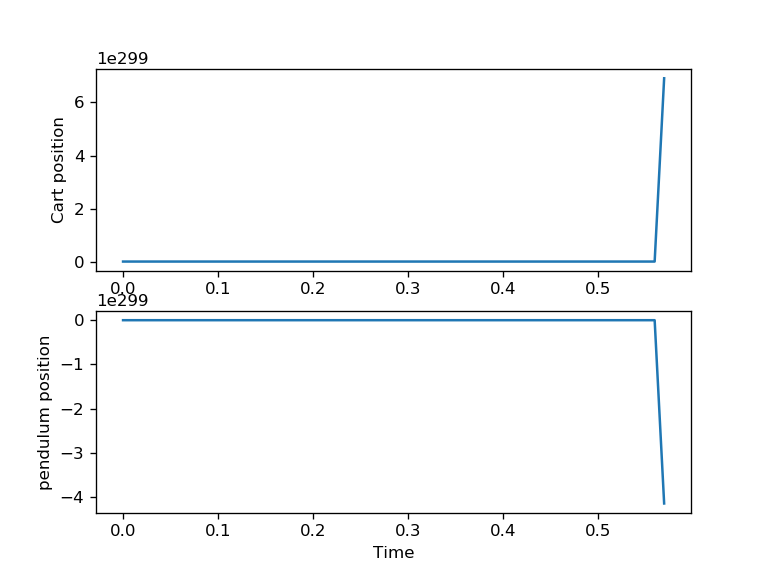

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAfwW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA+8ZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S0FxzClEFKxd1+TNS++zCta62/NP06dt9j0J6Dkf2rHaFv+dr20t1Bp3zX58
DBmkFpamrwUtoW26plf3qfo7kHaQyI08hEByMoaqItBilNRZ9xftAaNrfFzgbRx0zytlSZ7wyT/A
hWDCoOtQa0dEz95yhN3uVkH/sJoWqLvH6jo9pLsuTBPgi8kL8+yRBKPqVQ/YUDgwspb8Gnl6iUwZ
SurlWB0QXIgiBsb9xLD0CubzvixG8obluC6puxpOWyCYkAbatLU9jaC6EwsXEj+MlAWQBEJnFmon
oyTi8n0C0BKkW/r4xDr20Mgn+As9aPbE4158j/U2cEGxsD+LAx8n1ABol8bPKscdoc/NLOlg9pn4
16RMT+6SCUf+x7E0q2jztUa7lppa0uU7fP2cihnDlXP0SLhbPzcba+v6lTJont47ZpsCZxHf0yQC
KsNfufJ30ADdSnV2hwLCo9HvHLPbUaKXHDGoEHHo1WpVbro4AyhlKHS4R2POcQzDHQQpD01Egeg5
lEnIllRd2OJYfjP8tNQeyhkxZZ8vp9ng2KsnhBG2vCR+e8C6sinjAFN/BFpKmSmEo50v8xs0AE6N
/UE4OeRZBosW+0BvucH9m8bJ/lwr1tA7UQAUuwOto8aQoneNEU1oHnjFTQnvgNyjMNP0kpealaS5
m8cFk0UXO8jBucXBfOSpbLSxTfG82h1FTualEKTSftHmURQcNweaqaCK6IQJ7aDPKnIaIrGND/ly
e7C8cskfvJ+ONoDBweEoZr/wcIp95BBArj4BTJSzjfjhReDuvBRg+6EWdm9I6ACn7s8AAAMAWQ/4
L5IU7B/A1eFLvqdp5kqRtZtf/JdigJdemTBVG8a1vorjoq/vWz48+EuOKuxsrQY2//7gJV26qWWZ
XQUSB+z3+3x6Zfjk9nOyYOh1iOdZqwv+BAMTPHCLTHIn0c5rrGN4+67eCKUVfHnF8BlnBgAwf2bO
zuKos7BV2pQR0BKB7ezX7bksAVb8btOIAboVRnZa+kIntyiejIFNtu0if/PaW4uxBu8np++6gC4S
+lCku5duAa7zJcAAFRrOJlC+6wy4XG3A0F+/UkMTsEwKbV+3+FvC0TW50g3B6bOillAVJt3qhzGf
aNzb5342WjFWBqHXiKS6dQ6DJX827424ujDaTWILZcJPk2qt3V3ai/TOjJoV6+aGd2Jq3wuTiLb7
3YvNPx7zx1Wn06mR3IMchIfcdOO2o974E0vIHJZpVzRRVArojdMnuyokOyK/s0TGcU/IK1iv/Fmv
Hy7VueLR0lkjMN4BZdM+Qub76EM/YqCW//d97hGwN84wLiGbupLZ7vgqt7TaKEjfxQvsQOpDpk3i
X28jeWorVy0XtbDVdMIVqVpZo8mXbR7N8cpRbMZ1AYh234ZhZhb+sW7/NMAAJZNm45OWqKrh9z0M
tCD/qepNhhPI/IPuwQ5IfguODgFdGalMoDY0/SL3TDM1WDcGYjbqbR5xpIz55ohWo3OgE4aokH2X
PNRpLJNYs6/EMmIewJmZcuQTP9h2pf/fQcUjvOgq32KSXBzfzhqd/lkJzg6Msc9pB//VsFkcYgWn
lRiyzTx6AJwy7/E/S2+kigyzWnDY8P2zLOPx6Lu4FaHhGKV1nEUEpx6AoVbW+dZJmc2YzrBr1ttX
TJjVpviNJdyKzEG2pffGS737jf2YIj6jIGyWyiCR/H/cEyqiYhF8lvp+6uSlcXS1ui+yN1RbgHj3
TChIiCscck1ntXBjWCaO/SXnncnhKScv9YGNWfOK6yvFI5/UPdkFroIDeibAuA3R4MDhAjoULnh0
KmEDAA7+/kTptDgyaiV/ToU/ZfD7Wh+UL+tRgBnk1ND0DMYDTfp1i+q+fKv76mybdVHpmVc+/IZK
7D4ze9XGDGcxoNwGI9wWXQEgdPbuD9GDUaQCbq2g/CVOqrNmKdjYdk9ly5HYRljp8NBmlMXqA8hj
dd2Dokbe9jjpi4fnnor20AjdzIe3hoF3ZbOS6uJQUqxcKiptSd+MCZRwBTcbYEgfD01cBffvTg2G
UzKSqtAIK8EVQuHnEQbChjdwzcMO14UzHFOsYTLomf+JBnMTibeSi50ORg6X2w8QWQJeQqetlK/4
6oipCBvtlNuGcmXynfKmYUssI9kNyhQCTWaVS9mGFT+Mz0Bttm5vsc+RlzAM0t+BxQkSklmTIu7S
pjIoQKjBy6jhb7GncYn59pX9F4wSCFmIE5KgweuRAkWep2xOjSJNtjQGYUVWUgPdB8gtgOaAh+kr
K1ALfY4QAT/QnUN+2W3S3LM6cm2dfp59aNsUIZonULtkoE9FPpuBfgqE43hfW+5wYus9bkNcuGd2
eP0FOAAAkImPwOs2gAIk/LfkCQM90puGbooF9r/Jwg2Mnxp246y9jd/nwhGoGyBtGOy+QSie2Anf
5qvRVYdeaThY1GcyLKblgekbbcoMWf7MuBjWIJSrlNARzhjwpBr7p0T0cSQFBQ8nOkgB3FL2atHx
XLomohYLaMew+3LCwea94TK7FFLBuc31D2x9OZohaKuwt9/4ojuYNAKtCa03q/qhXxxDhUWrCbT5
MWmxtglomKapdlnkaFVaL0dXehdceDDSk34M11UK3ICBi3h/yOC6JicCdAAdBO+VlEgf+87Yhnmq
okc1zTu3V8Fv8vcQtLfh34LmY8YUMW7zKR6M7qEPUOyBb/bLG9dRTK+coK0VAWf4SgAjp2xgseVx
0xz6rU2yePPQmHEMdMaplM+wkz0Mjp+hH3QknIIka4X0c8e2bk64agbRHILhrrSigLcztgiEVZFx
vSfTdQZbSXE/3snYlLOOc

In [22]:
#Q4 What is the behavior of the system when starting with 𝑧0=[0.5,0.3,0.,0.]𝑇? Explain the behavior. 
# we create a cart pole
testCart = CartPole()
def Gains():
    # required variables
    g  = testCart.g
    T  = testCart.dt
    L  = testCart.l 
    Mc = testCart.mc
    Mp = testCart.mp
        
    A=np.array([[1.,0.,T,0.],[0.,1.,0.,T],[0.,T*Mp*g/Mc,1.,0],[0.,T*(Mc+Mp)*g/(Mc*L),0.,1.]])
    B=np.array([[0.],[0.],[T/Mc],[T/(Mc*L)]])
    Q=np.eye(4)*1
    Q[0,0]=Q[0,0]*100 #tune for position
    Q[1,1]=Q[1,1]*10 #tune for angle - more effective
    Q[2,2]=Q[2,2]*0.1 #tune for position
    Q[3,3]=Q[3,3]*1 #tune for angle less effective 
    R=np.eye(1)*0.001
    
    P0 = Q
    for n in range(100):
        C = np.dot(B.T, P0).dot(B)
        D = np.dot(B.T,P0).dot(A)
        Knew = -1*np.linalg.inv(R+C).dot(D)

        P0 = Q + np.dot(A.T,P0).dot(A)+np.dot(np.dot(np.dot(A.T,P0),B),Knew)
        #Pn.append(P0)
    
    print('Final gain, K:', Knew)
    return Knew,P0

K,P = Gains();

# Control inputs can be compute using these gains as:        
def useful_controller(z,i):
    
    #print(z)
    z_bar = np.array([0.,0.3, 0., 0]) # position to maintain
    #u = K.dot(z-z_t)
    u = K.dot(z-z_bar) #control inputs
    #print('u: \n',u)
    return u;
    

# we simulate the cart pole and display its behavior
z0 = np.array([0.5,0.3,0.,0.]) # Given initial state
horizon_length = 1000

z,u = testCart.simulate(z0, useful_controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')


animate_cart_pole(z, testCart.dt)

#### Explaination for question 4:
Here, the gains are claculated as per the code but they tend to make system more unstable. We have an underlying flawed assumption in the system virtue of which this is happening. As we have linearized our system about the pendulum up position, we can not say for sure that it will be a good approximation at other locations far from the fixed point too. In the case when initial condition is pendulum down, our linearized model can not replicate the true system's nature around that point, it still tries to impart more control using gains but that results in more and more drift from the desired position. These gains make the states so high that they blow up.

# Question 2:
We would like to use the linearized equation to compute an optimal controller that makes the cart follow a 0.5Hz sine trajectory of amplitude 1 (i.e. $x$ displacement from -1 to 1 meter) while keeping the pendulum balanced.

1. Write a cost function that will help enforce this behavior (be precise with the variables you use).
2. Compute the finite horizon controller that creates this behavior for $N=1000$ (i.e. 10 seconds).
3. Test the behavior of the robot using $z_0 = [0.5, \pi + 0.3, 0., 0.]^T$. Plot the time evolution of the control input and the states of the system. How well can you track the desired motion?
4. What is the cost value predicted by the control design? How does it compare to the real cost value when applied to the nonlinear system? Explain.

### Answers

1. The cost function to stablize the cart model can be computed by solving Ricatti equations. The of form:
$$ min \frac{1}{2}x^T_N Q_N x_N + q^T_N x_N + \sum^{N-1}_{n=0} \frac{1}{2}x^T_n Q_n x_n +q^T_n + \frac{1}{2}u_n R_n u_n $$ 
Here $Q_N$ is the terminal quadratic cost matrix for the system. $Q_n$ is quadratic cost matrix computed at each time stamp. $q_n$ is the variable corresponding to the desired trajectory and computed as $-Q_n \bar{x_n}$, where $\bar{x_n}$ is the desired trajectory to be followed. And $R_n$ is the cost on control inputs.

Using these matrices and solving Ricatti equations for each stage as follows:

$$K_n = -(R_n + B^T_n P_{n+1}B_n)^{-1}B^T_n P_{n+1}A_n$$
$$P_n = Q_n + A^T_n P_{n+1}A_n + A^T_n P_{n+1}B_n K_n$$
$$k_n = -(R_n + B^T_n P_{n+1}B_n)^{-1}B^T_n p_{n+1}$$
$$p_n = q_n + A^T_n p_{n+1} + A^T_n P_{n+1}B_n k_n$$

Moreover, here the control cost, $R$ (smaller for quick response) and state cost $Q$ matrix were taken as follows:
$$ Q = \begin{bmatrix} 700 & 0 & 0 & 0 \\ 0 & 8000 & 0 & 0 \\ 0 & 0 & 100 & 0 \\ 0 & 0 & 0 & 1000 \end{bmatrix}  \text{ and } R = 0.01 $$

The code implementation and solutions for question 2 and 3 are given below. 


Final gain, K: [[  186.04595 -1537.99169   248.01088  -513.75491]]


<IPython.core.display.Javascript object>


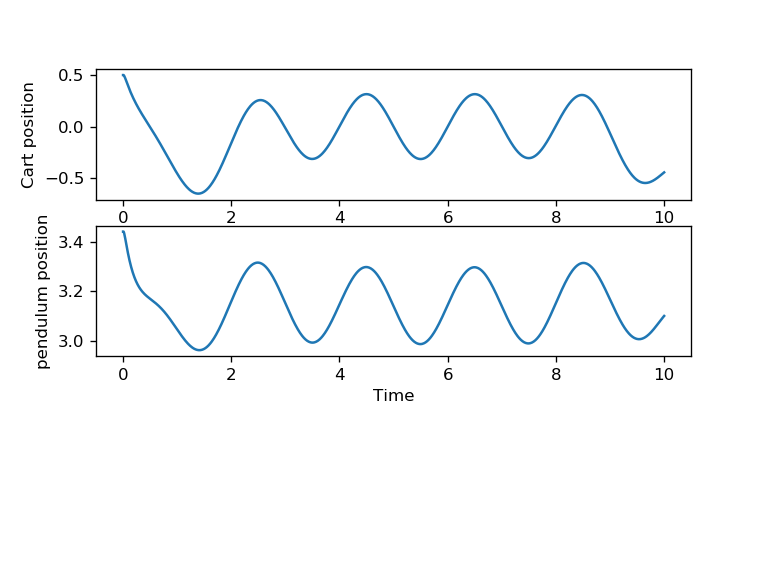

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABUlW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA/NZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S0FxzClEFKxd1+TNS++zCta62/NP06dt9j0J6Dkf2rHaFv+dr20t1Bp3zX58
DBmkFpamrwUtoW26plf3qfo7kHaQyI08hEByMoaqItBilNRZ9xftAaNrfFzgbRx0zytlSZ7wyT/A
hWDCoOtQa0dEz95yhN3uVkH/sJoWqLvH6jo9pLsuTBPgi8kL8+yRBKPqVQ/YUDgwspb8Gnl6iUwZ
SurlWB0QXIgiBsb9xLD0CubzvixG8obluC6puxpOWyCYkAba0V3dP1mvFov9YwTz1vV8L3LMrXut
l5SYtgJHbmzNn4zNGahylvII0PS5g4LAAsuS3Wp9r3qS1ur30uShGvDREY/tx/morhpsDwre5Vlk
7MnepZ6gY9aPf9duj9geK67A7KBKjl7XN8HqRO+z/T1sRDV2i9fHSV3SSGiHHPexhkyp/VQCHiQ/
enZlb8VPNLXumNCfbTnz1UGHX3+k8zdAcHsMsy+VPTsZys5Uydne4MfYwZr7QmFDVDX2nPu/QiOT
WbOmADGBkZUsI7Q62ErmdMlnUMr84hmGOghSHpryt+LHVtYL+EqfkOS5Fd2nI+nIFXUqLPl9Ps8G
xVk8IdyvDaVf5s8ZtLyuxi1+tAgevomEo9FsbpRsgD9ukkeOyQspg0WLfaA33Qh+Dk1GES9F2yBB
6zzLAyGGjxpCid40RTV72alQKiYrtmtncafrbHnuLcNCHpRddjajZZPVFXRLuJLMfplL7ZuAC9YL
DEWqxwWzcXQkDWLoi4sFswrF7X2cmIjX3/Z1fgwwsevlbRQj+rEDfRtOQtFRfl4HtGabksOASsBw
mNGaKfJPrekOpXhTv3b6Zsk0KCfVgb91v7bcLOCyimhjztDCnbIjFsXT9oxy6sgHF9Xl56bg0iS8
+sPJ/aYzsqGtn6iGynHIspOnAAADAJEWVsg+ENLH1YDQCICdR4o2P//Rh3N4N6o5OTEjmT7Ta0uu
cHQ4RmwA1gO9TG01Ejp9wxar/GQp/5Cr1VR/3aJpOyeP6JIbtwKqja4kUUsUe+EyzcHPrhNZE8vF
O73attUwy4KyS2NuQv6jS3TVun2fU7ibTxVoWJ/jgQ3EmF0gGdx72WX9C13cYpP5+qxN77dZPiSU
0KV12vsJ2XpM9EjZ0l3yRR3KwIcu5KPTgMAYaTReiWjoj6cv+Vt2zKilLr2Y8o9JRzXzvc9HP0uS
QZWnq//SvSlwqJZYj/bjlbPFwye2xv2bdLYEXI/urxXKcAAAKvA2q4S93pDtH5R01KEwDZJEDsTQ
Zx34M6kUtjP6bO/AHn1fAeLz9QXbeiGTqtJLwCfRhgWksrKrKYBeUrNx9hpjABet4iRrP02rWb0m
4YyxnrVT7lDoveJYL9Gv/LniSn6bSnClsfmErZ6N1EZn6/yj5gmt+vXhRLCFW7qnsm/P/7hvYhi1
dFq97jf/6o02C9SXdKPVXG23u5bWKaVRQ0pukJxBvNEDralczJijRM7dhGf0Rgsk4b5CQ+46cdtK
O1yVhPvICN1CwEwVen21kN0NeGSYpCz7NExnFPzy0Lqfsh30+2e1fGxF5gJM97wCy6Z8hq/vabSF
vr/1URdIokO8su6nww0W7BNMFVvabRQlYaWIgkCUgb8qEAv1POOHC+cilgfE+RmCIV/jqgl0pa1u
xri/Rc1CpyoKd8SCaS272zwPv0lsae2bjpbDvXz+nXUzkqLTTOiYKbZymong9Shpk/J4iaHrQi7H
eGWi8xZi3O+PEqdI+7WX038NhIVeoCH/EJJ/d0QpD32WbIR7BXJAwwuafQCZ83R9HMDZ3JPJfcLP
wRys+4a7XyMlefGBNvt2g+B0XE0W8S+WcpuSJ0b6bwWNwAO+JFYYNqsDVGQOXaV7xEvDK9httF/g
Gc557O17WQlI53e/cj6gz5Aa3p6DbZkEvzskHA9kojjep8pLQhFstL9ENd3hr+wFw4BqaTQNTu+s
3ctm19k9XG6x4/TZqf+xsU367IamCtEGis/YBLoS65IkRNUmTy+2+qdHq6WFh1pc9+PtbUZLI/IZ
1pyrYNAAxGcc/IviikZT/mP5VMSzojrMQxujt8F1XIHxqSU1A51n3GF6a0ZX2KUN2nWVU1liM3Z7
uuFQLbtWU981UbA81U/MJXMk1HXPOtUDwB9lvpNt3/kIhLaXI4ZoCTBhVHZ01fPlX99TZVrwO1HZ
XPvyGSuwwdlvLjtKhyH9Pj+nuBqIoX4h8vTfASzP4ttwLQXhe/mQNB79nbTU/2YyHmEBF0Omc2HI
8ZoKyqC1ausENwerfq4KfzqyVv8JrsiZBzLGAi+7/21oxq13bWhrhcIs74PsJc0a/2ho8Yh05HLY
/x81iPjJVogjJwI68FbldVk5BBsGFML4tP1sq0pmOKdYwZ7+0/7kPpx6uY3c8KViSU8HyYRVFp85
stse7CDrgvShv0RzBGYkJmfJ+7aL1I9t9o1//SsGm3qLXHwHvKY9AanHWonL+CKlouyIyEgylx3w
zLwGo8TTHOI2mpv3bmwNAEVBCYnZiIzKQ/hFoEWZruxvigd8HoyRgTwfRQ56vscx5vyJgkYC+slj
Os6GnedE4KPz0noNN5mhOK2wjYRO9vPrl4GKIZxhe+c8j6VdL/7h694ZOXuvInR0xbenk+VBKGrx
qz/bY/qqoDo767u8TtSZqUHEnz19KSlrovAJ0uVsC81NfUyh3D28JsaFPWNZjEQPxLHa0zrST4ec
yFj2Jn56n0kZEtRobiXuyBJidaubIk9pU+YnUVa+/zzAgXbAH2rAaTrapV6rrLIOzS+fnDxoL7t5
Qv8HO9O1sHNHtK6wA3Pe5

In [6]:
#Q2 and Q3 ARE DONE BELOW 
Cart2 = CartPole()

# Trajactory to follow, and
# Compute qn for each point

T  = Cart2.dt

Q=np.eye(4)*100
Q[0,0]=Q[0,0]*7 #tune for position
Q[1,1]=Q[1,1]*50 #tune for angle - more effective
Q[2,2]=Q[2,2]*1 #tune for position
Q[3,3]=Q[3,3]*10 #tune for angle - less effective 

R=np.eye(1)*0.01

points = np.arange(0,10,T)
S = np.empty([4,1000])
qn = np.empty([4,1000])

for i in range(horizon_length): # from zero to N
    S[0][i] = np.sin(2*np.pi*0.5*points[i])
    S[1][i] = 0
    S[2][i] = np.pi*np.cos(2*np.pi*0.5*points[i])
    S[3][i] = 0
    
    qn[:,i] = -1*Q.dot(S[:,i]) 
    
#print('qn: ',qn)
#print('Shape qn: ',qn.shape)
#print(S)
#print(np.shape(S))


def Gains():
    # required variables
    g  = Cart2.g
    T  = Cart2.dt
    L  = Cart2.l 
    Mc = Cart2.mc
    Mp = Cart2.mp
        
    A=np.array([[1.,0.,T,0.],[0.,1.,0.,T],[0.,T*Mp*g/Mc,1.,0],[0.,T*(Mc+Mp)*g/(Mc*L),0.,1.]])
    B=np.array([[0.],[0.],[T/Mc],[T/(Mc*L)]])
    Q=np.eye(4)*100
    Q[0,0]=Q[0,0]*7 #tune for position
    Q[1,1]=Q[1,1]*50 #tune for angle - more effective
    Q[2,2]=Q[2,2]*1 #tune for position
    Q[3,3]=Q[3,3]*10 #tune for angle less effective 
    R=np.eye(1)*0.01
    
    P0 = Q # last P
    p0 = qn[:,-1] # last p
    #print('p0',np.shape(p0))
    Kn = np.empty([1000,4])
    Pn = np.empty([1000,4,4])
    kn = np.empty([1000,1])
    pn = np.empty([1000,4,4])
    
    # In reverse order from N-1 to 0
    for n in range((horizon_length-1), -1, -1):
        C = np.dot(B.T, P0).dot(B)
        D = np.dot(B.T,P0).dot(A)
        d = np.dot(B.T,p0)
        #print('shape d',np.shape(d)) # = (1) sb 1
        
        Knew = -1*np.linalg.inv(R+C).dot(D)
        Kn[n,:] = Knew
        P0 = Q + np.dot(A.T,P0).dot(A) + np.dot(np.dot(np.dot(A.T,P0),B),Knew)
        #print('P0',np.shape(P0))
        Pn[n,:,:] = P0
        
        knew = -1*np.linalg.inv(R+C).dot(d)

        kn[n,:] = knew
        #print('shape kn',np.shape(kn))# = (1000,4) sb (1000,1)
        p0 = qn[:,n] + np.dot(A.T,p0) + np.dot(np.dot(np.dot(A.T,P0),B),knew)
        #print('po shape',p0)
        pn[n,:] = p0
        
        #print('Knew',np.shape(Knew))
        #print('knew', knew)
        #print('shape knew',np.shape(knew)) #= (1,)
        #print('pn shape',np.shape(pn))
        #one = qn[:,n]
        #print('one',np.shape(one))
        #two = np.dot(A.T,p0)
        #print('two',np.shape(two))
        #three = np.dot(np.dot(np.dot(A.T,P0),B),knew)
        #print('three',np.shape(three))
        #p0 = one + two + three
        #p0 = qn + np.dot(A.T,p0) + np.dot(np.dot(np.dot(A.T,P0),B),knew)
    
    print('Final gain, K:', Knew)
    #print('knew shape',np.shape(knew)) = 1
    return Kn,Pn,kn,pn



K,P,k,p = Gains();

#print('K',k)
#print('P',np.shape(P))
#print('k',np.shape(k))
#print('p',np.shape(p))



# Control inputs can be compute using these gains as:      
un = np.empty([1000,1])
def useful_controller(z,i):
    
    #print(z)
    z_bar = np.array([0.,np.pi,0.,0.]);
    #z_bar = np.array([0.5,0.3+np.pi,0.,0.])  # position to maintain
    u = K[i,:].dot(z-z_bar) + k[i] #control inputs + feedforward term
    #print('u: \n',u)
    un[i,:] = u
    return u;
    

#we simulate the cart pole and display its behavior
z0 = np.array([0.5,0.3+np.pi,0.,0.]) # Given initial state
horizon_length = 1000

z,u = Cart2.simulate(z0, useful_controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()

plt.subplot(3,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')

plt.subplot(3,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')

#plt.subplot(3,1,2)
#plt.plot(t,S[:,0])
#plt.ylabel('Sin Wave to track')

plt.xlabel('Time')

animate_cart_pole(z, Cart2.dt)


### Answer 4:
As mentioned in the previous answer, the cost value by the control design is fairly appropiate with respect to actual cost of non-linear system around the fixed point. This happens as the system is approximated around the fixed point. And through the results, it was visible that when model cost was computed at pendulum up position, which is fixed point too, the costs made system stable. But, in case of pendulum down position, model cost just made the system worse in depicting the real non-linear nature of the system.  